In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.geometry import shape
import matplotlib.pyplot as plt
import zipfile
import yagmail
import wget
import os
import requests


5 fires detected in the last hour.


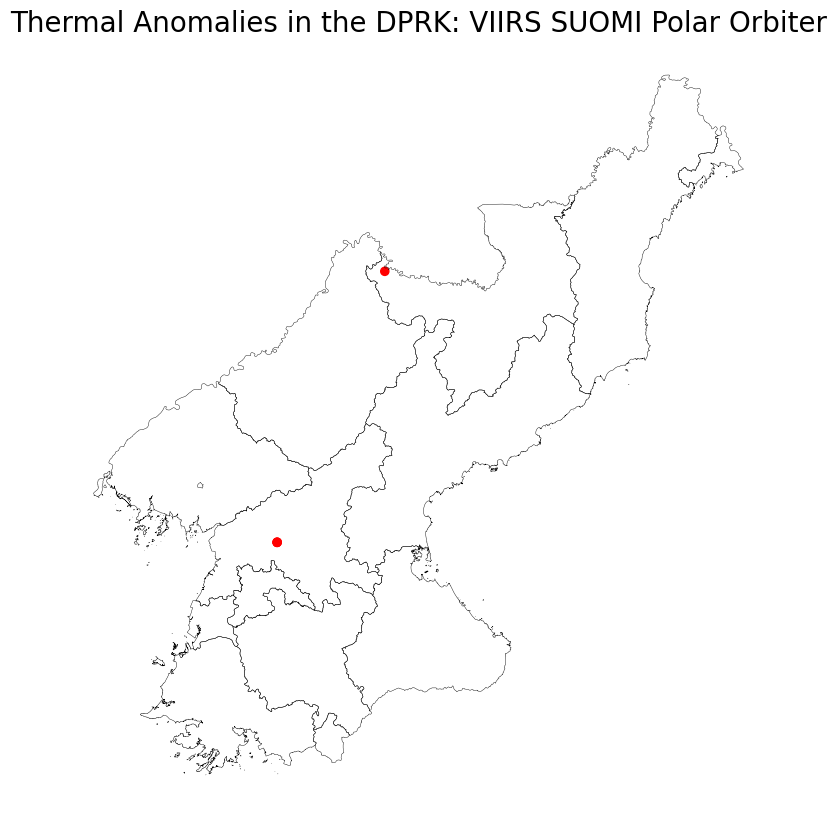

In [9]:
def sendAlert(content):  # Sends an email with given content

    user = yagmail.SMTP(user='nknews.thermalradar@gmail.com',
                        password='pknzhwayprlenjyi')
    user.send(to='ethan.jewell@nknews.org',
                 subject='[FIRE ALERT] -- Fires detected',
                 contents=content)


try:
    os.remove('/Users/ethanjewell/Desktop/Python Env/Scripting/ThermalRadar/RAW/SUOMI_VIIRS_C2_Russia_Asia_24h.zip')
except FileNotFoundError:
    print('No pre-existing file to delete; downloading latest data...')

wget.download('https://firms.modaps.eosdis.nasa.gov/data/active_fire/suomi-npp-viirs-c2/shapes/zips/SUOMI_VIIRS_C2_Russia_Asia_24h.zip',
              out='/Users/ethanjewell/Desktop/Python Env/Scripting/ThermalRadar/RAW/')

shape_zip = '/Users/ethanjewell/Desktop/Python Env/Scripting/ThermalRadar/RAW/SUOMI_VIIRS_C2_Russia_Asia_24h.zip'
with zipfile.ZipFile(shape_zip, 'r') as zip_ref:
    zip_ref.extractall(
        '/Users/ethanjewell/Desktop/Python Env/Scripting/ThermalRadar/RAW/')

border = gpd.read_file(
    '/Users/ethanjewell/Desktop/Python Env/Scripting/Map Data/Shapefiles/NATIONAL/National Borders with Provinces/National Borders with Provinces.shp')
fires = gpd.read_file(
    '/Users/ethanjewell/Desktop/Python Env/Scripting/ThermalRadar/RAW/SUOMI_VIIRS_C2_Russia_Asia_24h.shp')
pointInPolys = gpd.tools.sjoin(
    fires, border, predicate="intersects", how='inner')

axes = border.boundary.plot(figsize=(10, 10), color='black', linewidth=0.3)
axes.set_axis_off()

plot = pointInPolys.plot(ax=axes, color='red', markersize=(
    pointInPolys['BRIGHT_TI4']/100)**3)

plot.set_title(
    'Thermal Anomalies in the DPRK: VIIRS SUOMI Polar Orbiter', fontsize=20)

fires_only = pointInPolys[['name_en', 'BRIGHT_TI4']]

fires_for_email = fires_only.rename(
    columns={"name_en": "Province", "BRIGHT_TI4": "Brightness"})
print()
print(f'{len(fires_for_email)} fires detected in the last hour.')

if fires_for_email['Province'].str.contains('Pyongyang').any():
    sendAlert(
        f'Fire(s) detected in Pyongyang. Here\'re the most recent fires: \n {fires_for_email.to_html()}')

if len(fires_for_email) >= 5:
    sendAlert(
        f'Five or more fires detected in the DPRK. Here\'re the most recent fires: \n {fires_for_email.to_html()}')


In [12]:
# FOR THE FUTURE -- An attempt at using the API instead of downloading shapefiles with wget

def createDF():

    API = 'https://firms.modaps.eosdis.nasa.gov/api/country/csv/a1965c3e5f85c73b483a1ca7d4a0ea36/VIIRS_SNPP_NRT/PRK/3'
    response = requests.get(API)
    response.text

    rows = response.text.split('\n')
    detailed_rows = []

    i = 1

    while i < len(rows):
        detailed_rows.append(rows[i].split(','))
        i += 1

    df = pd.DataFrame(detailed_rows, columns = rows[0].split(','))
    return df
# point_df = df[['latitude', 'longitude']]
# point_tuples = list(point_df.itertuples(index=False, name=None))

# point_poly = []

# for point in point_tuples:
#     point_poly.append(Point(float(point[0]), float(point[1])))

# xs = [point.x for point in point_poly]
# ys = [point.y for point in point_poly]

# border = gpd.read_file('/Users/ethanjewell/Desktop/Python Env/Scripting/Map Data/Shapefiles/NATIONAL/National Borders with Provinces/National Borders with Provinces.shp')
# print(point_poly)

# fig, ax = plt.subplots()
# ax.plot(border)